#### REFERENCE
1. [Practical Deep Learning for Coder 2.0 -- Object Detection](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/06_Object_Detection.ipynb)

#### TO DO LIST
1. set up validation loss
2. show results (inference mode)
3. run model on kaggle notebook, generate submission

In [1]:
from fastai2.vision.all import *

%load_ext autoreload
%autoreload 2

<a id='1'></a>
#### 1. Take Reference from COCO Example

In [2]:
path = '/userhome/34/h3509807/.fastai/data/coco_tiny/train.json'
coco_json = json.load(open(path, 'r'))
coco_json.keys()

dict_keys(['categories', 'images', 'annotations'])

In [3]:
type(coco_json)

dict

In [4]:
coco_json['categories']

[{'id': 62, 'name': 'chair'},
 {'id': 63, 'name': 'couch'},
 {'id': 72, 'name': 'tv'},
 {'id': 75, 'name': 'remote'},
 {'id': 84, 'name': 'book'},
 {'id': 86, 'name': 'vase'}]

In [5]:
coco_json['images'][:3]

[{'id': 542959, 'file_name': '000000542959.jpg'},
 {'id': 129739, 'file_name': '000000129739.jpg'},
 {'id': 153607, 'file_name': '000000153607.jpg'}]

In [6]:
coco_json['annotations'][:3]

[{'image_id': 542959, 'bbox': [32.52, 86.34, 8.53, 9.41], 'category_id': 62},
 {'image_id': 542959, 'bbox': [98.12, 110.52, 1.95, 4.07], 'category_id': 86},
 {'image_id': 542959, 'bbox': [91.28, 51.62, 3.95, 5.72], 'category_id': 86}]

<a id='2'></a>
#### 2. Convert CSV to COCO JSON

In [7]:
import re

def read_bbox_str(x):
    bbox = re.findall("([0-9]+[.]?[0-9]*)", x)
    return [i for i in map(float, bbox)]

In [8]:
data_path = Path('/userhome/34/h3509807/wheat-data')
df = pd.read_csv(data_path / 'train.csv')

In [9]:
df.head(3)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1


#### 2a. Recover Categories, Annotations, Images 

In [10]:
cats = [{'id': 1, 'name': 'wheat'}]

In [11]:
ann_dict = df.to_dict(orient = 'index')
ann_ls = []
for _, d in ann_dict.items():
    # remove unwanted keys
    for k in ['width', 'height', 'source']:
        d.pop(k, None)
    d['category_id'] = 1
    d['bbox'] = read_bbox_str(d['bbox'])
    ann_ls.append(d)
ann_ls[:3]

[{'image_id': 'b6ab77fd7',
  'bbox': [834.0, 222.0, 56.0, 36.0],
  'category_id': 1},
 {'image_id': 'b6ab77fd7',
  'bbox': [226.0, 548.0, 130.0, 58.0],
  'category_id': 1},
 {'image_id': 'b6ab77fd7',
  'bbox': [377.0, 504.0, 74.0, 160.0],
  'category_id': 1}]

In [12]:
imgs = [
    {'id': d['image_id'], 'file_name': f"{d['image_id']}.jpg"} for d in ann_ls
]
imgs[:3]

[{'id': 'b6ab77fd7', 'file_name': 'b6ab77fd7.jpg'},
 {'id': 'b6ab77fd7', 'file_name': 'b6ab77fd7.jpg'},
 {'id': 'b6ab77fd7', 'file_name': 'b6ab77fd7.jpg'}]

In [13]:
train_meta = {'categories': cats, 'images': imgs, 'annotations': ann_ls}

with open('train.json', 'w') as f:
    json.dump(train_meta, f)

In [14]:
data_path.ls()

(#5) [Path('/userhome/34/h3509807/wheat-data/bkup'),Path('/userhome/34/h3509807/wheat-data/train'),Path('/userhome/34/h3509807/wheat-data/train.csv'),Path('/userhome/34/h3509807/wheat-data/sample_submission.csv'),Path('/userhome/34/h3509807/wheat-data/test')]

<a id='3'></a>
#### 3. Read Training Data

In [15]:
json_path = 'train.json'
imgs, lbl_bbox = get_annotations(json_path)

In [16]:
imgs[:3]

['b6ab77fd7.jpg', 'b53afdf5c.jpg', '7b72ea0fb.jpg']

In [17]:
imgs[1], lbl_bbox[1]

('b53afdf5c.jpg',
 ([[988.0, 781.0, 1024.0, 877.0],
   [331.0, 863.0, 401.0, 958.0],
   [47.0, 226.0, 112.0, 272.0],
   [682.0, 974.0, 790.0, 1024.0],
   [63.0, 988.0, 219.0, 1024.0],
   [824.0, 901.0, 873.0, 978.0],
   [815.0, 413.0, 905.0, 485.0],
   [468.0, 161.0, 640.0, 227.0],
   [888.0, 537.0, 964.0, 611.0],
   [3.0, 88.0, 109.0, 157.0],
   [266.0, 657.0, 323.0, 733.0],
   [582.0, 771.0, 776.0, 854.0],
   [77.0, 653.0, 195.0, 729.0],
   [673.0, 433.0, 821.0, 525.0],
   [620.0, 673.0, 739.0, 780.0],
   [224.0, 760.0, 314.0, 842.0],
   [160.0, 933.0, 339.0, 1003.0],
   [961.0, 784.0, 1014.0, 945.0],
   [392.0, 497.0, 570.0, 564.0],
   [0.0, 536.0, 116.0, 611.0],
   [838.0, 761.0, 926.0, 871.0],
   [542.0, 222.0, 693.0, 297.0],
   [157.0, 2.0, 238.0, 56.0],
   [206.0, 0.0, 418.0, 72.0],
   [91.0, 114.0, 141.0, 188.0],
   [0.0, 234.0, 79.0, 312.0],
   [128.0, 328.0, 208.0, 440.0],
   [31.0, 305.0, 155.0, 427.0],
   [143.0, 442.0, 194.0, 539.0],
   [223.0, 319.0, 264.0, 362.0],
   [0.

In [18]:
img2bbox = dict(zip(imgs, lbl_bbox))

<a id='4'></a>
#### 4. Setup DataBlock and DataLoaders
- [dihedral transform ~~ rotation + flip](https://docs.fast.ai/vision.transform.html#_dihedral)

#### Questions
1. why get_train_imgs is needed? what is noop?

In [19]:
# define list of function objects
getters = [
    lambda o: data_path / 'train' / o, 
    lambda o: img2bbox[o][0], 
    lambda o: img2bbox[o][1]
]

In [20]:
def get_train_imgs(noop):
    return imgs

In [21]:
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [22]:
dblock = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter = RandomSplitter(),
                 get_items = get_train_imgs, 
                 getters = getters,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms,
                 n_inp = 1)

In [23]:
dls = dblock.dataloaders(data_path / 'train')

/userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [24]:
dls.c = 2

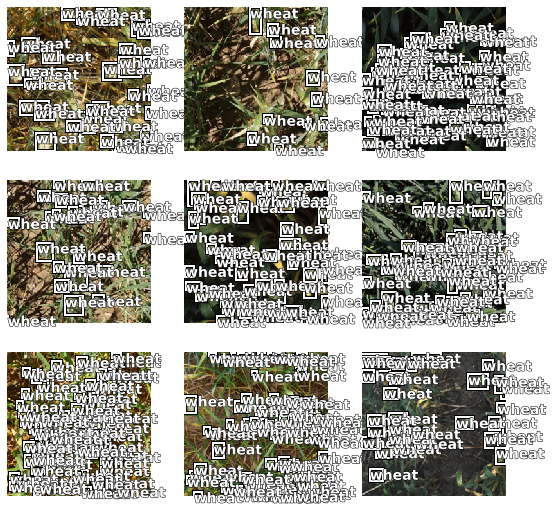

In [25]:
dls.show_batch();

In [26]:
b = dls.one_batch()
b[0].shape, b[1].shape # (BS, BBOX CNT, BBOX PARAM)

(torch.Size([64, 3, 224, 224]), torch.Size([64, 94, 4]))

<a id='5'></a>
#### 5. Setup Model

In [27]:
#!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
#cp -r "Practical-Deep-Learning-for-Coders-2.0/Computer Vision/imports" .
#mv imports ext_imports

In [28]:
from ext_imports import *

In [29]:
encoder = create_body(resnet34, pretrained = True)
get_c(dls)

2

In [30]:
arch = RetinaNet(encoder, get_c(dls), final_bias = -4)

#### 5a. Closer Look at RetinaNet Architecture

In [31]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [32]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [33]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

<a id='6'></a>
#### 6. Setup Loss, Metrics, Learner

In [36]:
ratios = [1/2,1,2]
scales = [1, 2*(1/3), 2*(2/3)]
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [37]:
# only freeze encoder, everything else unfreeze
def _retinanet_split(m): 
    return L(
        m.encoder,
        nn.Sequential(m.c5top6, m.p6top7, 
                      m.merges, m.smoothers, 
                      m.classifier, m.box_regressor)
        ).map(params)

In [38]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [39]:
learn.freeze()

<a id='7'></a>
#### 7. Model Training

In [40]:
import warnings 
warnings.filterwarnings("ignore")

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=0.004365158267319202)

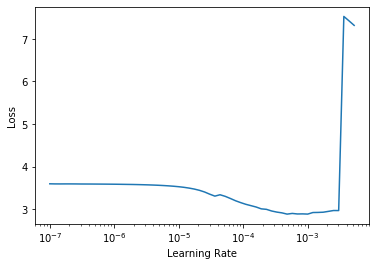

In [41]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,time


#### 8. Inference Mode